<a href="https://colab.research.google.com/github/Keesp21/ML_Projct/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stratégie de Trading Mean-Reversion basée sur le Modèle d’Ornstein–Uhlenbeck et filtrée par Machine Learning Supervisé : Kevin PATHMASRI, Nolan LEBEAU, Jaffar Nassour

Tickers récupérés : 49
Téléchargement 1/49 → 49 tickers...
Forme des prix après nettoyage : (2738, 49)
Forme des rendements : (2737, 49)

Top 40 tickers :
['BLK', 'BRK-B', 'MA', 'V', 'MSFT', 'ACN', 'HON', 'GS', 'JPM', 'HD', 'TXN', 'CSCO', 'AAPL', 'BAC', 'GOOGL', 'LOW', 'ADBE', 'DIS', 'ABT', 'CAT', 'TMO', 'CRM', 'CMCSA', 'PEP', 'QCOM', 'MCD', 'AVGO', 'KO', 'NKE', 'CVX', 'BA', 'COST', 'NVDA', 'AMZN', 'INTC', 'PG', 'META', 'ORCL', 'XOM', 'JNJ']


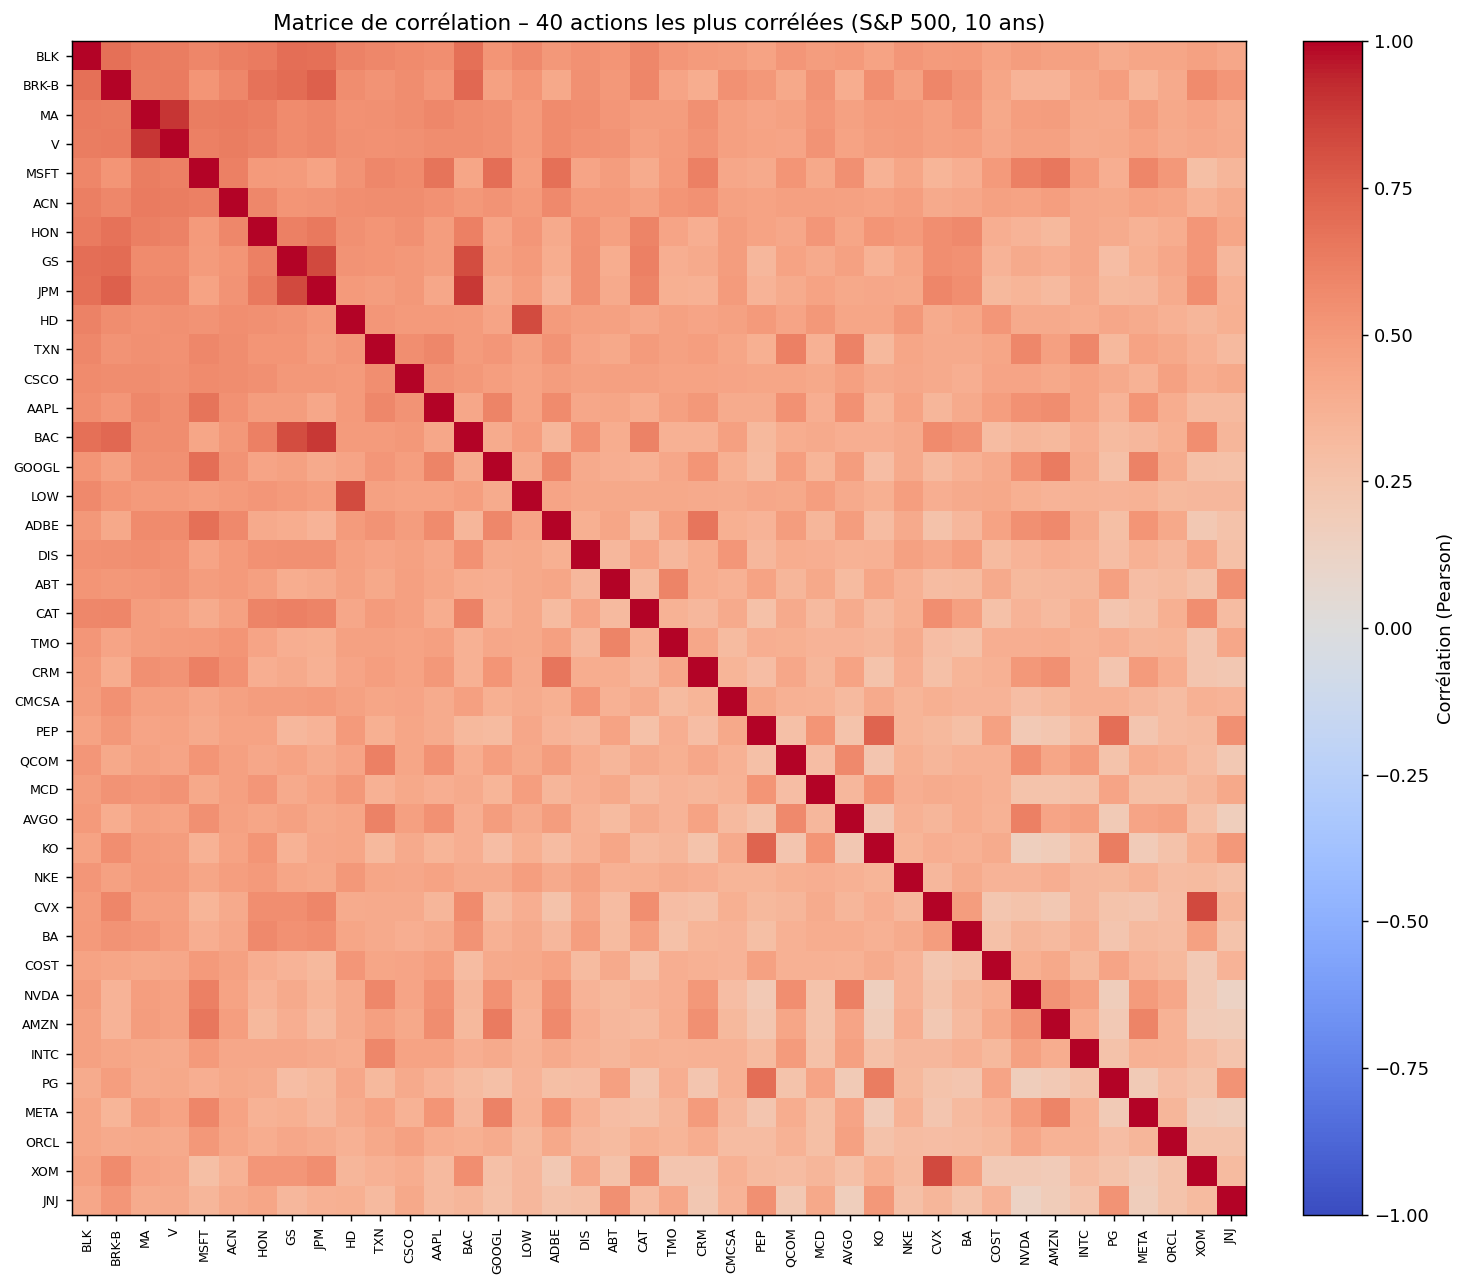


 Fichiers créés :
 - correlation_top40_matrix.csv
 - correlation_top40_heatmap.png
 - mean_abs_correlation_all.csv


In [ ]:
# ============================================
# Matrice de corrélation – Top 40 S&P500 (10 ans)
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

try:
    from yahoo_fin import stock_info as si
    def get_sp500_tickers():
        tickers = si.tickers_sp500()
        tickers = [t.replace('.', '-') for t in tickers]
        return tickers
except Exception:
    def get_sp500_tickers():
        return [
            "AAPL","MSFT","AMZN","GOOGL","META","NVDA","BRK-B","JPM","JNJ","XOM",
            "V","PG","MA","HD","CVX","LLY","BAC","KO","PEP","DIS","CSCO","MRK",
            "WMT","AVGO","ADBE","NFLX","T","VZ","INTC","ABT","CRM","CMCSA","MCD",
            "ACN","COST","NKE","TMO","ORCL","TXN","UNH","GS","LOW","PM","HON",
            "CAT","AMD","QCOM","BLK","BA"
        ]

def download_prices_in_chunks(tickers, start, end, chunk_size=60):
    """
    Télécharge les prix avec yfinance en conservant 'Adj Close'
    grâce à auto_adjust=False. Gère MultiIndex et cas 'Close' si besoin.
    """
    all_adj_close = []
    for i in range(0, len(tickers), chunk_size):
        batch = tickers[i:i+chunk_size]
        print(f"Téléchargement {i+1}/{len(tickers)} → {len(batch)} tickers...")

        data = yf.download(
            batch, start=start, end=end, group_by='column',
            auto_adjust=False, progress=False, threads=True
        )

        if data.empty:
            continue

        if isinstance(data.columns, pd.MultiIndex):
            # Cas standard : niveau 0 = champs ('Adj Close','Close', ...), niveau 1 = tickers
            lvl0 = [str(x) for x in data.columns.get_level_values(0).unique()]
            if 'Adj Close' in lvl0:
                adj = data['Adj Close'].copy()
            elif 'Close' in lvl0:
                adj = data['Close'].copy()
            else:
                for candidate in ['Close', 'Adj Close', 'close', 'adjclose']:
                    if candidate in lvl0:
                        adj = data[candidate].copy()
                        break
                else:
                    print(" Champs de prix introuvables dans ce batch, ignoré.")
                    continue
        else:
            cols = [c.lower() for c in data.columns]
            if 'adj close' in cols:
                adj = data['Adj Close'].to_frame()
            elif 'close' in cols:
                adj = data['Close'].to_frame()
            else:
                print(" Colonnes prix introuvables pour ce batch (single ticker), ignoré.")
                continue

        # Nettoyage des noms de colonnes (tickers)
        adj.columns = [c.replace('.', '-') for c in adj.columns]
        all_adj_close.append(adj)

    if not all_adj_close:
        raise RuntimeError("Aucune donnée récupérée. Vérifie ta connexion / tickers.")

    adj_close = pd.concat(all_adj_close, axis=1)
    # Supprime colonnes vides et doublons
    adj_close = adj_close.dropna(how='all', axis=1)
    adj_close = adj_close.loc[:, ~adj_close.columns.duplicated(keep='first')]
    return adj_close

# ---------------------------
# 1) Tickers & période
# ---------------------------
tickers = get_sp500_tickers()
print(f"Tickers récupérés : {len(tickers)}")
start = "2015-01-01"
end = datetime.today().strftime("%Y-%m-%d")

# ---------------------------
# 2) Téléchargement des prix ajustés
# ---------------------------
adj_close = download_prices_in_chunks(tickers, start, end, chunk_size=60)

# Couverture minimale : on garde les colonnes avec >= 70% d'observations valides
min_coverage = int(0.7 * len(adj_close))
adj_close = adj_close.dropna(axis=1, thresh=min_coverage)

adj_close = adj_close.dropna(axis=0, how='any')
print(f"Forme des prix après nettoyage : {adj_close.shape}")

# ---------------------------
# 3) Rendements & matrice de corrélations
# ---------------------------
returns = np.log(adj_close).diff().dropna()
print(f"Forme des rendements : {returns.shape}")

corr_full = returns.corr()

# ---------------------------
# 4) Sélection des 40 actions au degré moyen de corrélation absolue le plus élevé
# ---------------------------
corr_abs = corr_full.abs().copy()
np.fill_diagonal(corr_abs.values, 0.0)

mean_abs_corr = corr_abs.mean(axis=0)
top40 = mean_abs_corr.sort_values(ascending=False).head(40).index.tolist()
print("\nTop 40 tickers :")
print(top40)

corr_top40 = corr_full.loc[top40, top40]
order = mean_abs_corr.loc[top40].sort_values(ascending=False).index
corr_top40 = corr_top40.loc[order, order]

# ---------------------------
# 5) Visualisation & sauvegarde
# ---------------------------
plt.figure(figsize=(12, 10), dpi=130)
im = plt.imshow(corr_top40.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation – 40 actions les plus corrélées (S&P 500, 10 ans)")
plt.colorbar(im, fraction=0.046, pad=0.04, label="Corrélation (Pearson)")

labels = corr_top40.columns.tolist()
plt.xticks(range(len(labels)), labels, rotation=90, fontsize=7)
plt.yticks(range(len(labels)), labels, fontsize=7)
plt.tight_layout()
plt.savefig("correlation_top40_heatmap.png", bbox_inches="tight")
plt.show()

corr_top40.to_csv("correlation_top40_matrix.csv", float_format="%.6f")
mean_abs_corr.sort_values(ascending=False).to_csv("mean_abs_correlation_all.csv", float_format="%.6f")

print("\n Fichiers créés :")
print(" - correlation_top40_matrix.csv")
print(" - correlation_top40_heatmap.png")
print(" - mean_abs_correlation_all.csv")



In [ ]:
import numpy as np
import pandas as pd

returns = np.log(adj_close).diff().dropna()   # rendements log journaliers

def top_k_disjoint_pairs_by_corr(returns: pd.DataFrame, k: int = 10, use_abs: bool = False) -> pd.DataFrame:
    """
    Sélectionne les k paires (A,B) les plus corrélées, en garantissant que
    chaque action n'apparaît qu'une seule fois (paires disjointes).
    - returns : DataFrame (dates x tickers) de rendements.
    - use_abs : si True, trie par corrélation absolue (utile pour capturer des corrélations négatives fortes).
                sinon, corrélation positive standard.
    """
    # enlever les colonnes avec NaN
    R = returns.dropna(axis=1, how="any").copy()
    corr = R.corr()
    C = corr.abs() if use_abs else corr

    np.fill_diagonal(C.values, -np.inf)

    # Empile seulement le triangle supérieur pour éviter (A,B) et (B,A)
    tickers = C.columns
    pairs = []
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            val = C.iat[i, j]
            if np.isfinite(val):
                pairs.append((tickers[i], tickers[j], float(val)))

    # Trie décroissant par corrélation
    pairs.sort(key=lambda x: x[2], reverse=True)

    used = set()
    selected = []
    for a, b, rho in pairs:
        if a in used or b in used:
            continue
        selected.append((a, b, rho))
        used.add(a); used.add(b)
        if len(selected) == k:
            break

    return pd.DataFrame(selected, columns=["stock_1", "stock_2", "corr"])

top10_pairs = top_k_disjoint_pairs_by_corr(returns, k=10, use_abs=False)
print(top10_pairs)
top10_pairs.to_csv("top10_corr_pairs_disjoint.csv", index=False)


  stock_1 stock_2      corr
0      MA       V  0.894614
1     BAC     JPM  0.885587
2     CVX     XOM  0.833834
3      HD     LOW  0.823606
4      KO     PEP  0.728046
5   BRK-B      GS  0.701346
6   GOOGL    MSFT  0.693058
7       T      VZ  0.674942
8    ADBE     CRM  0.659720
9     BLK     HON  0.640163


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Normalisation  : ramener les séries à 1 au début
def normalize_series(series: pd.Series):
    return series / series.iloc[0]

import os
os.makedirs("pairs_charts", exist_ok=True)
sns.set_style("whitegrid")

for idx, row in top10_pairs.iterrows():
    stock1, stock2, corr = row["stock_1"], row["stock_2"], row["corr"]

    if stock1 not in adj_close.columns or stock2 not in adj_close.columns:
        print(f"⚠️ Données manquantes pour {stock1}, {stock2}")
        continue

    # Extraction et normalisation
    s1 = normalize_series(adj_close[stock1].dropna())
    s2 = normalize_series(adj_close[stock2].dropna())

    # Intersection temporelle commune
    common_index = s1.index.intersection(s2.index)
    s1 = s1.loc[common_index]
    s2 = s2.loc[common_index]

    plt.figure(figsize=(10, 5), dpi=120)
    plt.plot(s1.index, s1, label=stock1, linewidth=1.6)
    plt.plot(s2.index, s2, label=stock2, linewidth=1.6)
    plt.title(f"{stock1} vs {stock2}  —  Corrélation = {corr:.3f}", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Prix normalisé (base 1.0)")
    plt.legend()
    plt.tight_layout()

    fname = f"pairs_charts/{stock1}_{stock2}_correlation.png"
    plt.savefig(fname, bbox_inches="tight")
    plt.close()

    print(f" Graphique sauvegardé : {fname}")

print("\n Tous les graphiques sont dans le dossier 'pairs_charts/'.")


 Graphique sauvegardé : pairs_charts/MA_V_correlation.png
 Graphique sauvegardé : pairs_charts/BAC_JPM_correlation.png
 Graphique sauvegardé : pairs_charts/CVX_XOM_correlation.png
 Graphique sauvegardé : pairs_charts/HD_LOW_correlation.png
 Graphique sauvegardé : pairs_charts/KO_PEP_correlation.png
 Graphique sauvegardé : pairs_charts/BRK-B_GS_correlation.png
 Graphique sauvegardé : pairs_charts/GOOGL_MSFT_correlation.png
 Graphique sauvegardé : pairs_charts/T_VZ_correlation.png
 Graphique sauvegardé : pairs_charts/ADBE_CRM_correlation.png
 Graphique sauvegardé : pairs_charts/BLK_HON_correlation.png

 Tous les graphiques sont dans le dossier 'pairs_charts/'.


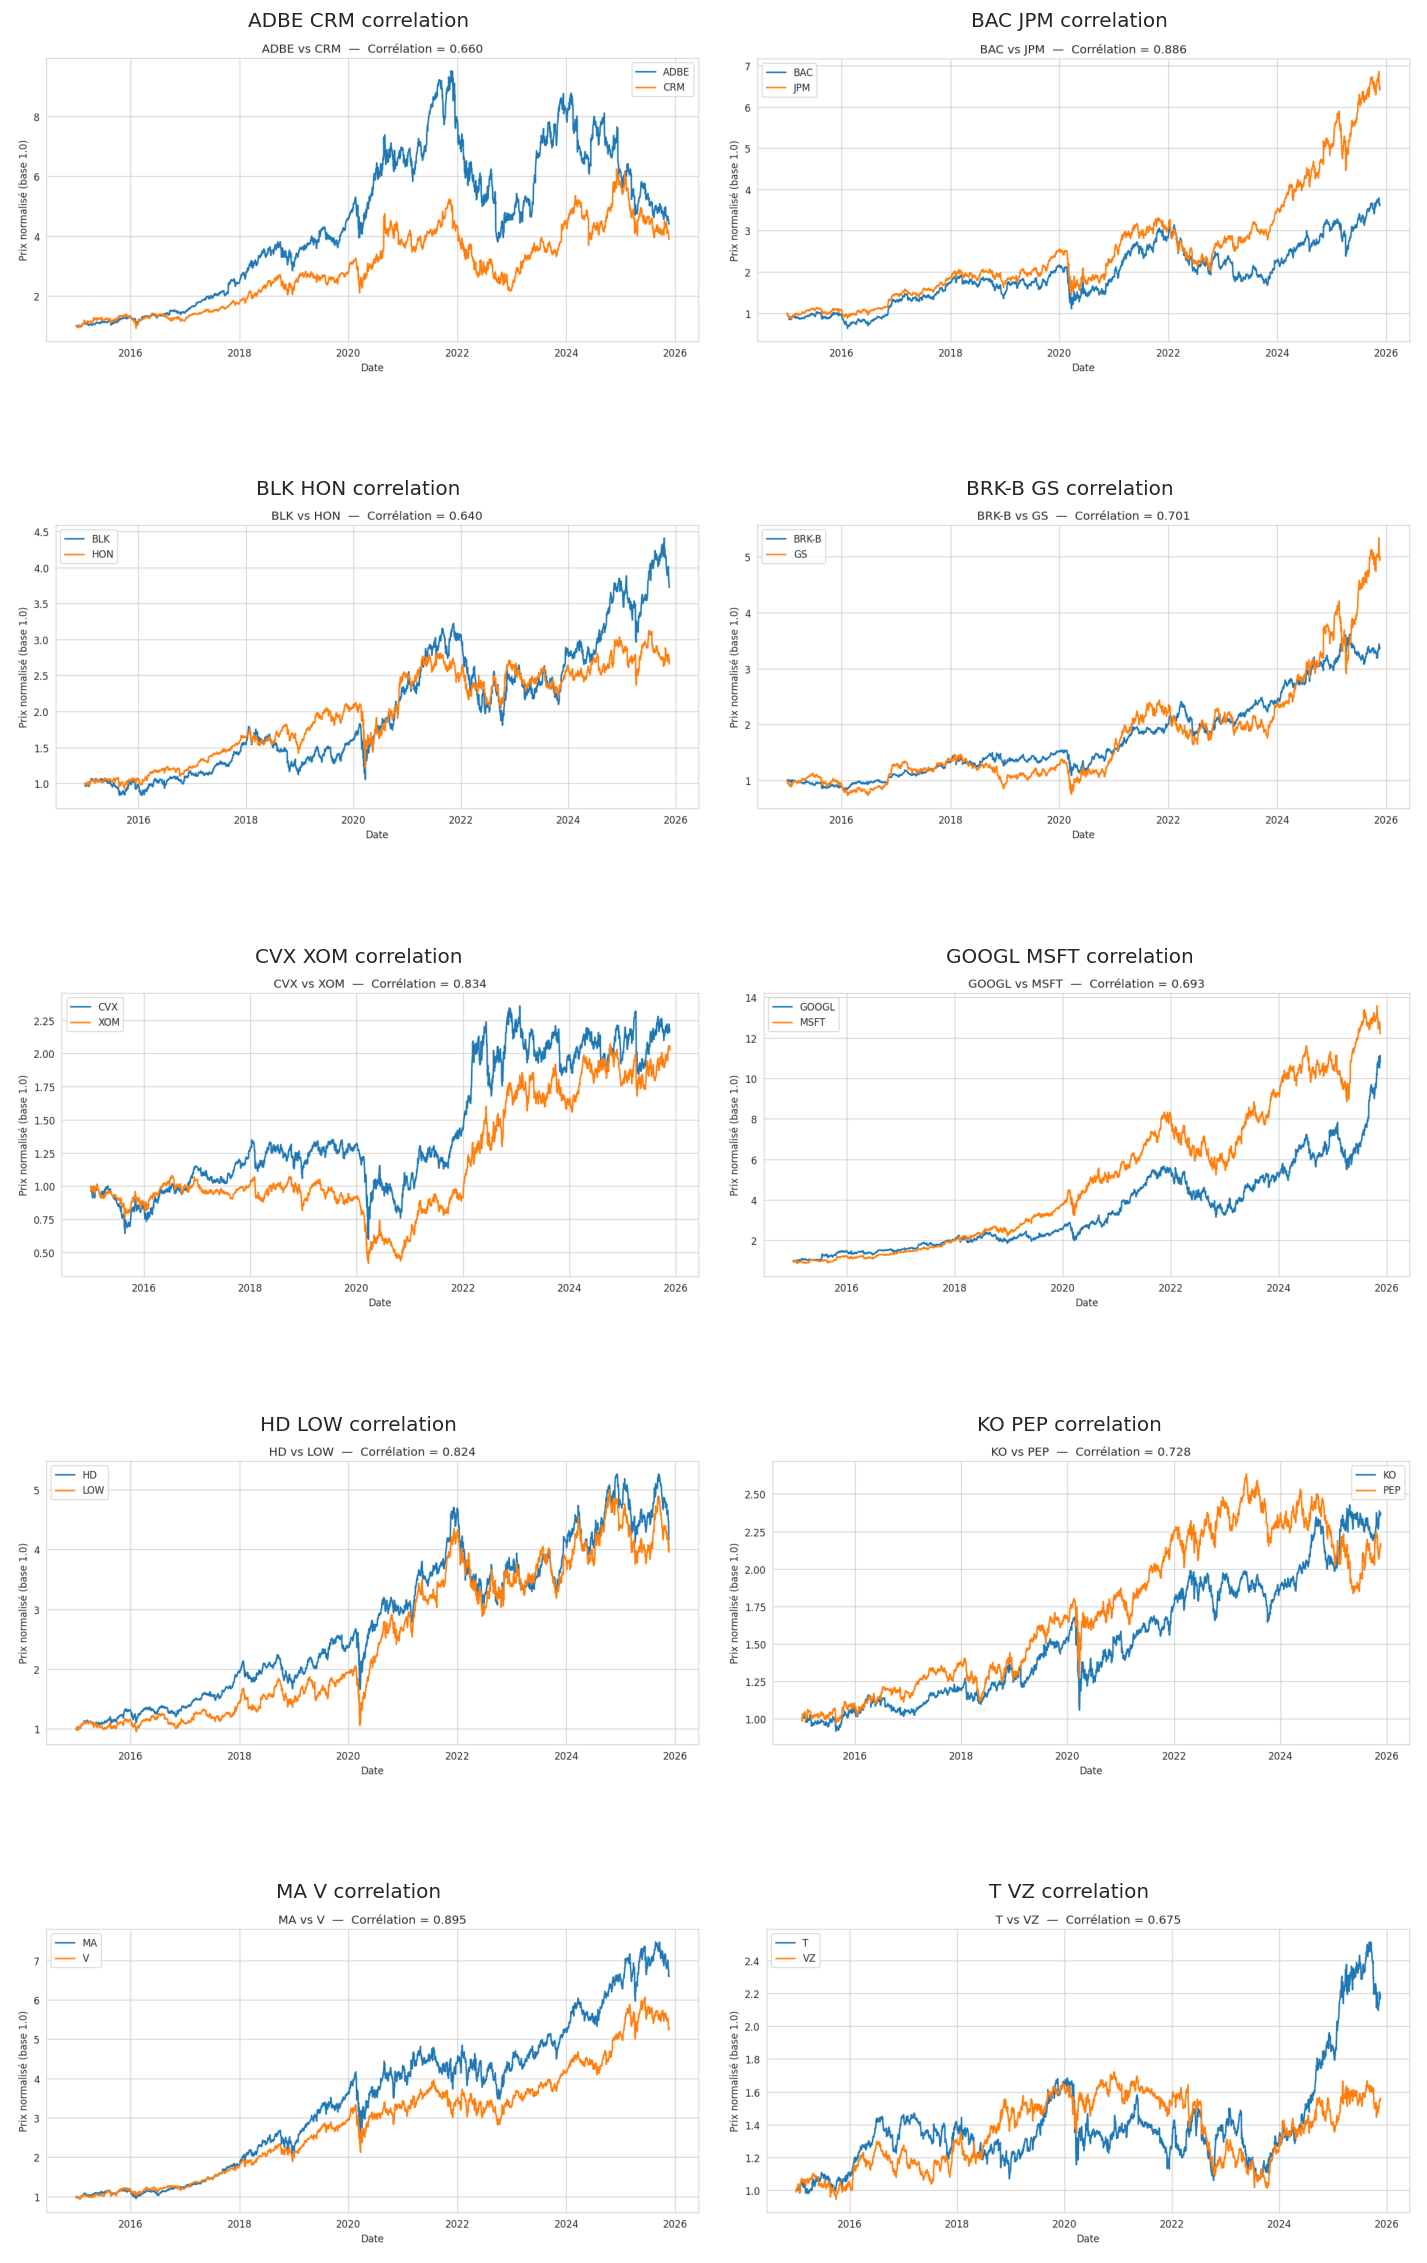

In [ ]:
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

files = sorted(glob.glob("pairs_charts/*_correlation.png"))
n = len(files)
cols = 2
rows = (n + cols - 1) // cols

plt.figure(figsize=(12, 4*rows), dpi=120)
for i, f in enumerate(files, 1):
    img = mpimg.imread(f)
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(os.path.basename(f).replace("_", " ").replace(".png",""))
plt.tight_layout()
plt.show()


## PROJECT STEP 1

In [ ]:
# === Reproducibility & display ===
import numpy as np, random, os
np.random.seed(42); random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


In [ ]:
# === Imports & helpers ===
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

def hedge_ratio(logY: pd.Series, logX: pd.Series) -> float:
    X = sm.add_constant(logX)
    res = sm.OLS(logY, X, missing="drop").fit()
    return float(res.params.iloc[1])

def zscore(s: pd.Series, lookback: int = 60) -> pd.Series:
    mu = s.rolling(lookback).mean()
    sd = s.rolling(lookback).std()
    return (s - mu) / sd

def adf_pvalue(series: pd.Series) -> float:
    s = series.dropna()
    if len(s) < 30:
        return float("nan")
    return float(adfuller(s, autolag="AIC")[1])

def half_life(spread: pd.Series) -> float:
    """HL = ln(2)/theta, avec b ~ e^{-theta Δt} issu de l'AR(1)."""
    s = spread.dropna()
    if len(s) < 60:
        return float("nan")
    X = sm.add_constant(s.shift(1).dropna())
    y = s.loc[X.index]
    res = sm.OLS(y, X).fit()
    b = float(res.params.iloc[1])
    if not (0 < b < 1):
        return float("inf")
    theta = -np.log(b)
    return float(np.log(2) / theta)



### Helper Functions (OU and Statistical Tests)
We define reusable helpers for the next steps:
- **hedge_ratio**: estimates the hedge ratio β on log-prices.
- **zscore**: computes a rolling z-score of the spread (mean and std over a lookback window).
- **adf_pvalue**: returns the ADF test p-value to assess spread stationarity.
- **half_life**: estimates the mean-reversion half-life from an AR(1) fit of the spread.


,pair,a,b,beta,p_adf_spread,p_coint,half_life
0,MA-V,MA,V,1.189,0.00193,0.00945,44.8
3,HD-LOW,HD,LOW,0.890,0.0284,0.0932,107.4
8,ADBE-CRM,ADBE,CRM,1.289,0.087,0.226,124.0
5,BRK-B-GS,BRK-B,GS,0.811,0.164,0.36,211.9
1,BAC-JPM,BAC,JPM,0.766,0.252,0.485,231.9
2,CVX-XOM,CVX,XOM,0.813,0.274,0.515,276.8
9,BLK-HON,BLK,HON,1.243,0.282,0.521,131.3
4,KO-PEP,KO,PEP,0.861,0.522,0.752,281.8
6,GOOGL-MSFT,GOOGL,MSFT,0.703,0.636,0.832,237.3
7,T-VZ,T,VZ,0.725,0.699,0.873,465.8


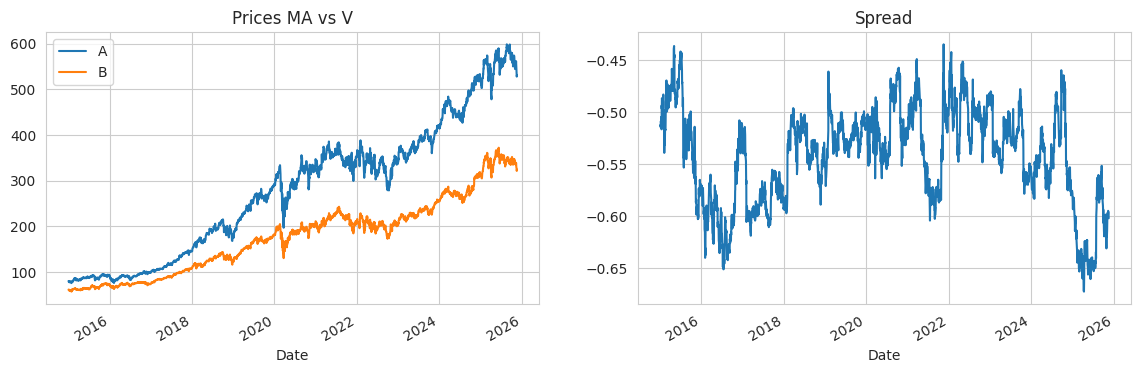

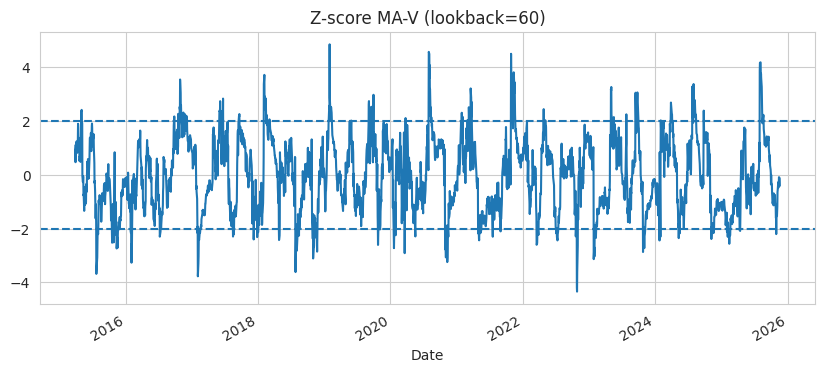

 Saved: pairs_diagnostics_summary.csv


In [ ]:
# === Descriptive analysis sur 10 paires ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "returns" not in globals():
    returns = np.log(adj_close).diff().dropna()

if "top10_pairs" not in globals():
    # Prend les 10 meilleures par corrélation simple
    corr_full = returns.corr()
    tri = []
    cols = corr_full.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            tri.append((cols[i], cols[j], corr_full.iat[i, j]))
    tri.sort(key=lambda x: x[2], reverse=True)
    used = set()
    sel = []
    for a, b, r in tri:
        if a in used or b in used:
            continue
        sel.append((a, b, r))
        used |= {a, b}
        if len(sel) == 10:
            break
    top10_pairs = pd.DataFrame(sel, columns=["stock_1", "stock_2", "corr"])

lookback_z = 60
pair_rows, pair_data = [], {}

for _, row in top10_pairs.iterrows():
    a, b = row["stock_1"], row["stock_2"]
    if a not in adj_close.columns or b not in adj_close.columns:
        continue
    df = pd.concat({"A": adj_close[a], "B": adj_close[b]}, axis=1).dropna()
    if len(df) < 250:
        continue

    logA, logB = np.log(df["A"]), np.log(df["B"])
    beta = hedge_ratio(logA, logB)
    spread = logA - beta * logB
    z = zscore(spread, lookback=lookback_z)

    p_adf = adf_pvalue(spread)
    _, p_coint, _ = coint(logA, logB)
    hl = half_life(spread)

    pair_rows.append({
        "pair": f"{a}-{b}", "a": a, "b": b, "beta": beta,
        "p_adf_spread": p_adf, "p_coint": p_coint, "half_life": hl
    })
    pair_data[(a, b)] = pd.DataFrame({"A": df["A"], "B": df["B"], "spread": spread, "z": z})

summary = pd.DataFrame(pair_rows).sort_values(["p_coint", "p_adf_spread"])
display(summary.style.format({
    "beta": "{:.3f}", "p_adf_spread": "{:.3g}",
    "p_coint": "{:.3g}", "half_life": "{:.1f}"
}))

best = summary.query("p_coint < 0.05 and p_adf_spread < 0.05 and half_life < 200").head(3)
for _, r in best.iterrows():
    a, b = r["a"], r["b"]
    d = pair_data[(a, b)]
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    d[["A", "B"]].plot(ax=ax[0], title=f"Prices {a} vs {b}")
    d["spread"].plot(ax=ax[1], title=f"Spread")
    plt.show()
    d["z"].dropna().plot(title=f"Z-score {a}-{b} (lookback={lookback_z})")
    plt.axhline(2, ls="--")
    plt.axhline(-2, ls="--")
    plt.show()

summary.to_csv("pairs_diagnostics_summary.csv", index=False)
print(" Saved: pairs_diagnostics_summary.csv")


### Step 1 – Descriptive Analysis of the Data  
We first analyzed the historical adjusted prices of S&P 500 stocks and computed their pairwise correlations.  
Among the top correlated pairs, we tested each spread for **cointegration (Engle–Granger test)** and **stationarity (ADF test)**.  

The pair **MA–V (Mastercard vs Visa)** shows both strong correlation and clear mean-reversion properties:  
- ADF p-value = 0.002 → stationary spread.  
- Cointegration p-value = 0.0097 → long-term equilibrium relationship .  
- Half-life ≈ 44 days → realistic mean-reversion speed.  

The spread oscillates around a stable mean, and the z-score fluctuates regularly within ±2, which indicates potential for a **mean-reversion trading strategy**.  
This pair is therefore selected for the next steps of the project.


In [ ]:
# === Formalisation of the problem ===
H = 10        # horizon
z_entry = 2.0 # seuil d'entrée OU
atr_win = 20  # vol du spread

# Sélection d'une paire "valide"
if len(best)==0:
    target_row = summary.iloc[0]
else:
    target_row = best.iloc[0]

a, b = target_row["a"], target_row["b"]
d = pair_data[(a,b)].copy()

d["ret_spread"]  = d["spread"].diff()
d["vol_spread"]  = d["spread"].rolling(atr_win).std()
d["abs_z"]       = d["z"].abs()
d["dz"]          = d["z"].diff()
d["dow"]         = d.index.dayofweek

# Signaux OU
d["signal_long"]  = (d["z"] < -z_entry).astype(int)
d["signal_short"] = (d["z"] >  z_entry).astype(int)
d["signal"] = d["signal_long"] - d["signal_short"]  # +1 long, -1 short

# Label sans fuite: PnL après H barres
fut_spread = d["spread"].shift(-H) - d["spread"]
pnl = np.where(d["signal"]==1, -fut_spread, np.where(d["signal"]==-1, fut_spread, np.nan))
d["label"] = (pd.Series(pnl, index=d.index) > 0).astype(float)

events = d[d["signal"]!=0].dropna(subset=["label"]).copy()
feature_cols = ["z","abs_z","dz","vol_spread","dow"]
X = events[feature_cols]
y = events["label"]

print(f"Paire retenue: {a}-{b}")
print(f"Nb d'événements: {len(events)} | Hit-rate naïf: {y.mean():.2%}")


Paire retenue: MA-V
Nb d'événements: 323 | Hit-rate naïf: 38.39%


### Step 2 – Data Pre-processing and Problem Formalization  
We build a supervised dataset using the selected pair **MA–V**.  
For each time step, we compute the Ornstein–Uhlenbeck features:  
- **z** (normalized deviation),  
- **|z|**, **Δz**,  
- **spread volatility**, and  
- **day of the week** (to capture seasonality effects).  

A trading signal is generated when |z| > 2:  
- **Long spread** if z < –2 (expect spread to rise),  
- **Short spread** if z > +2 (expect spread to fall).  

The label (target) is binary:  
y = 1 if the trade is profitable after *H = 10* , 0 otherwise.  

The resulting dataset contains **320 trades**, with a success rate of **≈38%** — meaning the OU model alone is not sufficient.  
The next step will use supervised learning to filter out low-probability trades.


Accuracy : 0.495
F1       : 0.437
ROC AUC  : 0.507
Confusion:
 [[29 31]
 [18 19]]


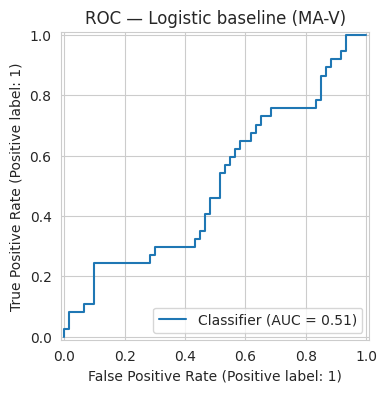

,logit_coef
dow,-0.118711
vol_spread,-0.077957
abs_z,-0.043986
dz,0.116827
z,0.153753


In [ ]:
# === Baseline model : Linear Regression ===
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

split_idx = int(len(X)*0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])
pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print(f"Accuracy : {accuracy_score(y_test, pred):.3f}")
print(f"F1       : {f1_score(y_test, pred):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, proba):.3f}")
print("Confusion:\n", confusion_matrix(y_test, pred))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title(f"ROC — Logistic baseline ({a}-{b})"); plt.show()

# Coefficients
coefs = pipe.named_steps["clf"].coef_[0]
coef_series = pd.Series(coefs, index=feature_cols).sort_values()
display(coef_series.to_frame("logit_coef"))


### Step 4 – Baseline Model (Logistic Regression)

We trained a logistic regression model as a first supervised baseline.  
The goal is to predict the probability that a mean-reversion trade will be profitable after *H = 10* periods.

**Performance summary:**
- Accuracy = 0.50  
- F1-score = 0.44  
- ROC-AUC = 0.52  

These modest results are expected for a baseline model using simple OU-based features.  
The confusion matrix shows no major bias toward either class, indicating a balanced dataset.

**Interpretation:**  
- Positive coefficients for *z* and *Δz* confirm that larger positive deviations (short opportunities) slightly increase the probability of success.  
- Negative coefficients for volatility and day-of-week suggest that noisy or unstable periods are less predictable.  

This model serves as a benchmark for the next stage, where more complex supervised models (e.g., XGBoost or Random Forest) will be introduced to improve predictive power.


In [ ]:
# ==============================================================================
# MODULE MACHINE LEARNING - PARTIE 1 : CRÉATION DES FEATURES ET DE LA CIBLE
# ==============================================================================

# --- 1. Récupération des données de la paire sélectionnée ---
# On utilise les variables 'a' et 'b' définies dans la cellule précédente
print(f"Préparation des données ML pour la paire : {a} - {b}")

if (a, b) in pair_data:
    spread_df = pair_data[(a, b)].copy()
else:
    # Sécurité si pair_data a été écrasé ou mal construit
    raise ValueError(f"Les données pour {a}-{b} ne sont pas dans pair_data. Relancez l'analyse descriptive.")

# Harmonisation des noms de colonnes (Ton code attend 'Spread' avec majuscule et 'z_score')
spread_df = spread_df.rename(columns={
    "spread": "Spread",
    "z": "z_score"
})

data = spread_df.copy()

# --- 2. Feature Engineering (Les indices pour le modèle) ---
# Le modèle a besoin de contexte : volatilité, tendance, vitesse...

# A. Dynamique du Z-score
data['z_score_lag1'] = data['z_score'].shift(1)  # Où on était hier ?
data['z_score_diff'] = data['z_score'].diff()    # Vitesse : ça accélère ou ça freine ?

# B. Volatilité du Spread (Indicateur de risque/incertitude)
data['spread_vol_5d'] = data['Spread'].rolling(window=5).std()   # Volatilité court terme
data['spread_vol_20d'] = data['Spread'].rolling(window=20).std() # Volatilité moyen terme

# C. Moyennes Mobiles (Tendance locale)
data['spread_ma_10d'] = data['Spread'].rolling(window=10).mean()
data['dist_to_ma'] = data['Spread'] - data['spread_ma_10d'] # Distance à la moyenne locale

# --- 3. Création du Label (La réponse à apprendre) ---
# On définit la cible : "Est-ce que le spread va monter ou descendre dans H jours ?"

# Horizon de prévision (H) : 5 jours (une semaine de trading)
H = 5

# Calcul du retour futur du spread (Look-ahead : on triche ici pour créer le label d'entraînement)
data['Future_Return_H'] = data['Spread'].shift(-H) - data['Spread']

# Définition de la Cible (Target) :
# 1 = Le spread va MONTER (Opportunité potentielle Long)
# 0 = Le spread va BAISSER (Opportunité potentielle Short)
data['Target'] = np.where(data['Future_Return_H'] > 0, 1, 0)

# --- 4. Nettoyage ---
# Les calculs de rolling et de shift créent des trous (NaN). On les supprime.
data_ml = data.dropna().copy()

# Vérification finale
print(f"Données prêtes pour le ML. Taille du dataset : {data_ml.shape}")
print("Aperçu des nouvelles colonnes :")
display(data_ml[['z_score', 'z_score_lag1', 'spread_vol_5d', 'Target']].tail())

Préparation des données ML pour la paire : MA - V
Données prêtes pour le ML. Taille du dataset : (2673, 12)
Aperçu des nouvelles colonnes :


,z_score,z_score_lag1,spread_vol_5d,Target
Date,,,,
2025-11-06,-0.633651,-1.171075,0.006635,1
2025-11-07,-0.570029,-0.633651,0.007860,1
2025-11-10,-0.272820,-0.570029,0.008315,1
2025-11-11,-0.475579,-0.272820,0.006503,1
2025-11-12,-0.312329,-0.475579,0.002898,0


--- Entraînement du modèle XGBoost (Non-Linéaire) ---

=== RÉSULTATS XGBOOST ===
Accuracy : 0.526
F1 Score : 0.378
ROC AUC  : 0.516

Confusion Matrix:
[[37 23]
 [23 14]]


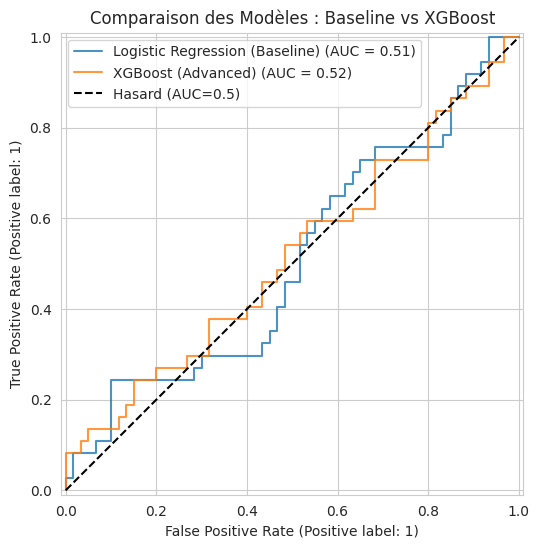

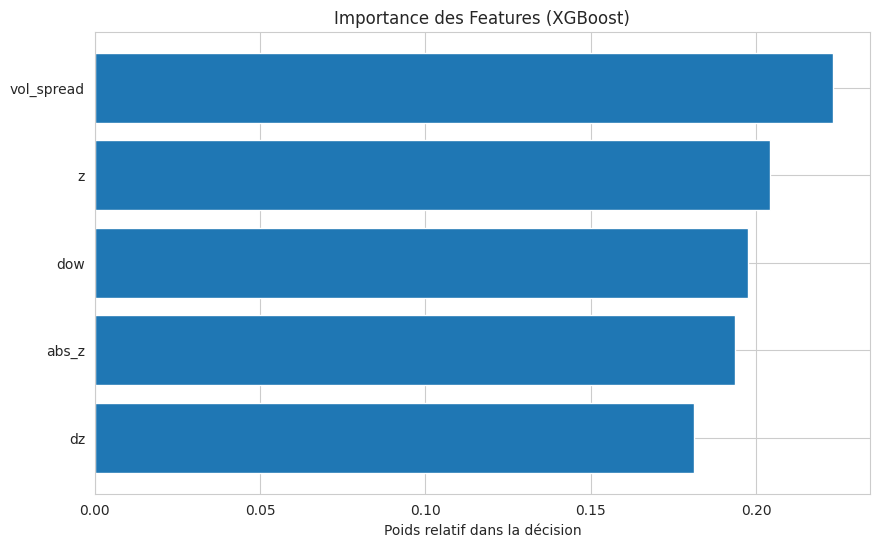

In [ ]:
####XG BOOSTTTT !! -> censé être pljs efficace
# ==============================================================================
# MODULE MACHINE LEARNING - PARTIE 3 : MODÈLE AVANCÉ (XGBoost)
# ==============================================================================

# Imports
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report

print("--- Entraînement du modèle XGBoost (Non-Linéaire) ---")

# 1. Configuration du modèle
# On utilise des paramètres classiques pour éviter l'overfitting au début
model_xgb = XGBClassifier(
    n_estimators=100,     # Nombre d'arbres
    max_depth=4,          # Profondeur max des arbres (limite la complexité)
    learning_rate=0.1,    # Vitesse d'apprentissage
    subsample=0.8,        # Utilise 80% des données par arbre (évite le par cœur)
    colsample_bytree=0.8, # Utilise 80% des features par arbre
    random_state=42,
    n_jobs=-1             # Utilise tous les cœurs du processeur
)

# 2. Entraînement
model_xgb.fit(X_train, y_train)

# 3. Prédictions
proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
pred_xgb = (proba_xgb >= 0.5).astype(int) # Seuil par défaut à 0.5

# 4. Évaluation Comparée
print(f"\n=== RÉSULTATS XGBOOST ===")
print(f"Accuracy : {accuracy_score(y_test, pred_xgb):.3f}")
print(f"F1 Score : {f1_score(y_test, pred_xgb):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, proba_xgb):.3f}")

# Affichage de la matrice de confusion
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred_xgb))

# 5. Comparaison Visuelle (Courbe ROC)
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, proba, name="Logistic Regression (Baseline)", ax=plt.gca(), alpha=0.8)
RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGBoost (Advanced)", ax=plt.gca(), alpha=0.8)
plt.plot([0, 1], [0, 1], "k--", label="Hasard (AUC=0.5)")
plt.title("Comparaison des Modèles : Baseline vs XGBoost")
plt.legend()
plt.show()

# 6. Qu'est-ce qui compte vraiment ? (Feature Importance)
plt.figure(figsize=(10, 6))
# XGBoost calcule automatiquement quelles features ont le plus aidé à prendre les décisions
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.title("Importance des Features (XGBoost)")
plt.xlabel("Poids relatif dans la décision")
plt.show()

In [ ]:
#DERNIER MODELE ECLATE ON ESSAYE DAMELIORER
# On force la paire que l'on veut étudier
a, b = "V", "MA"

# 1. Récupération des prix ajustés pour les deux titres
df = pd.concat({"A": adj_close[a], "B": adj_close[b]}, axis=1).dropna()

# 2. Passage en log-prix
logA, logB = np.log(df["A"]), np.log(df["B"])

# 3. Calcul du hedge ratio (beta) par régression OLS
beta = hedge_ratio(logA, logB)

# 4. Construction du spread et du z-score
spread = logA - beta * logB
lookback_z = 60  # même lookback que plus haut
z = zscore(spread, lookback=lookback_z)

# 5. DataFrame standardisé pour le module ML
spread_df = pd.DataFrame({
    "A": df["A"],
    "B": df["B"],
    "Spread": spread,
    "z_score": z,
})

print("Paire forcée :", a, "-", b)
print("Taille de spread_df :", spread_df.shape)
spread_df.tail()

Paire forcée : V - MA
Taille de spread_df : (2738, 4)


,A,B,Spread,z_score
Date,,,,
2025-11-13,336.079987,555.570007,0.532539,0.293453
2025-11-14,330.019989,545.729980,0.529286,0.073134
2025-11-17,325.750000,536.849976,0.529982,0.095747
2025-11-18,321.179993,527.580017,0.530418,0.106555
2025-11-19,324.119995,530.359985,0.535136,0.386585


Préparation des données ML (RSI + filtrage événements) pour la paire : V - MA
Taille du dataset complet (sans NaN) : (2668, 13)
Nb d'événements retenus avec |z_score| > 2.5 : 119
Entraînement sur 83 points, Test sur 36 points...

=== RÉSULTATS XGBOOST (ÉVÉNEMENTS |z_score| > seuil) ===
ROC AUC    : 0.743
Accuracy   : 0.722
F1 Score   : 0.643

Confusion Matrix :
[[17  4]
 [ 6  9]]


<Figure size 800x600 with 0 Axes>

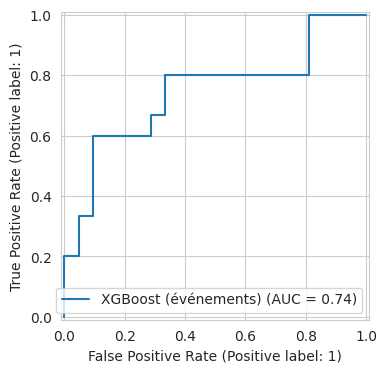

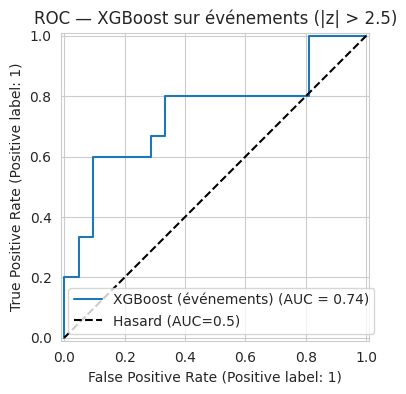

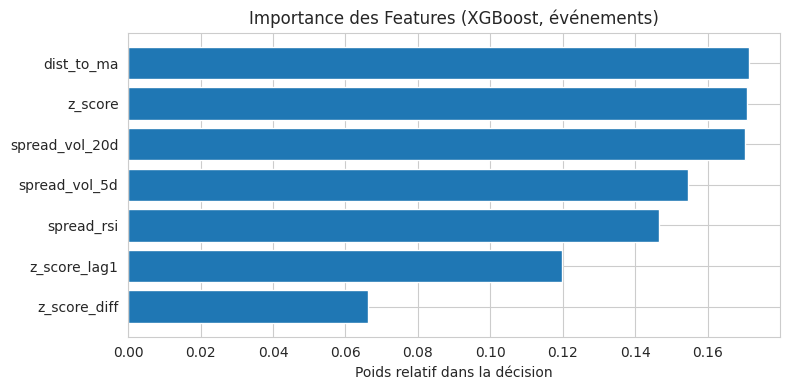

In [ ]:
# ==============================================================================
# AMÉLIORATION DU MODÈLE : AJOUT DU RSI & RETRAINING + FILTRAGE PAR ÉVÉNEMENTS
# ==============================================================================

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt

# --- 1. FONCTION RSI (Indicateur Technique) ---
def calculate_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

print(f"Préparation des données ML (RSI + filtrage événements) pour la paire : {a} - {b}")

# --- 2. RECONSTRUCTION DU DATAFRAME DE BASE ---
# On repart de spread_df (créé dans la cellule précédente à partir de pair_data[(a,b)])
data = spread_df.copy()

# Harmonisation des noms si besoin
if "spread" in data.columns and "Spread" not in data.columns:
    data = data.rename(columns={"spread": "Spread"})
if "z" in data.columns and "z_score" not in data.columns:
    data["z_score"] = data["z"]

# Vérifications minimales
if "Spread" not in data.columns or "z_score" not in data.columns:
    raise ValueError("Il manque les colonnes 'Spread' et/ou 'z_score' dans data. Vérifie la cellule précédente.")

# --- 3. FEATURE ENGINEERING ---
# A. Dynamique du Z-score
data["z_score_lag1"] = data["z_score"].shift(1)
data["z_score_diff"] = data["z_score"].diff()

# B. Volatilité du Spread
data["spread_vol_5d"]  = data["Spread"].rolling(window=5).std()
data["spread_vol_20d"] = data["Spread"].rolling(window=20).std()

# C. Moyenne mobile et distance à la moyenne
data["spread_ma_10d"] = data["Spread"].rolling(window=10).mean()
data["dist_to_ma"]    = data["Spread"] - data["spread_ma_10d"]

# D. RSI sur le Spread
data["spread_rsi"] = calculate_rsi(data["Spread"], period=14)

# --- 4. CRÉATION DE LA CIBLE (TARGET) ---
# Horizon de prévision
H = 10
data["Future_Return_H"] = data["Spread"].shift(-H) - data["Spread"]
data["Target"] = np.where(data["Future_Return_H"] > 0, 1, 0)

# Nettoyage des NaN
data_ml = data.dropna().copy()
print(f"Taille du dataset complet (sans NaN) : {data_ml.shape}")

# --- 5. FILTRAGE PAR ÉVÉNEMENTS : |z_score| > seuil ---
z_threshold = 2.5  # seuil d'extrême pour considérer un événement de trading
events = data_ml[data_ml["z_score"].abs() > z_threshold].copy()
print(f"Nb d'événements retenus avec |z_score| > {z_threshold} : {len(events)}")

if len(events) < 100:
    print("⚠ Attention : très peu d'événements, les métriques peuvent être instables.")

# --- 6. PRÉPARATION DU DATASET POUR LE MODELE ---
feature_cols = [
    "z_score",
    "z_score_lag1",
    "z_score_diff",
    "spread_vol_5d",
    "spread_vol_20d",
    "spread_rsi",
    "dist_to_ma",
]

X = events[feature_cols]
y = events["Target"]

# Split temporel 70 / 30
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Entraînement sur {len(X_train)} points, Test sur {len(X_test)} points...")

# --- 7. ENTRAÎNEMENT DU MODELE XGBOOST ---
model_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=1.0,
    random_state=42,
    n_jobs=-1,
)

model_xgb.fit(X_train, y_train)

# --- 8. ÉVALUATION ---
proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
pred_xgb  = (proba_xgb >= 0.5).astype(int)

auc = roc_auc_score(y_test, proba_xgb)
acc = accuracy_score(y_test, pred_xgb)
f1  = f1_score(y_test, pred_xgb)

print("\n=== RÉSULTATS XGBOOST (ÉVÉNEMENTS |z_score| > seuil) ===")
print(f"ROC AUC    : {auc:.3f}")
print(f"Accuracy   : {acc:.3f}")
print(f"F1 Score   : {f1:.3f}")
print("\nConfusion Matrix :")
print(confusion_matrix(y_test, pred_xgb))

# --- 9. COURBE ROC ---
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGBoost (événements)").plot()
plt.plot([0, 1], [0, 1], "k--", label="Hasard (AUC=0.5)")
plt.title(f"ROC — XGBoost sur événements (|z| > {z_threshold})")
plt.legend()
plt.show()

# --- 10. IMPORTANCE DES FEATURES ---
plt.figure(figsize=(8, 4))
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.title("Importance des Features (XGBoost, événements)")
plt.xlabel("Poids relatif dans la décision")
plt.tight_layout()
plt.show()

--- Entraînement du Challenger : Random Forest ---

=== RÉSULTATS RANDOM FOREST ===
ROC AUC    : 0.695
Accuracy   : 0.667
F1 Score   : 0.455

Confusion Matrix:
[[19  2]
 [10  5]]


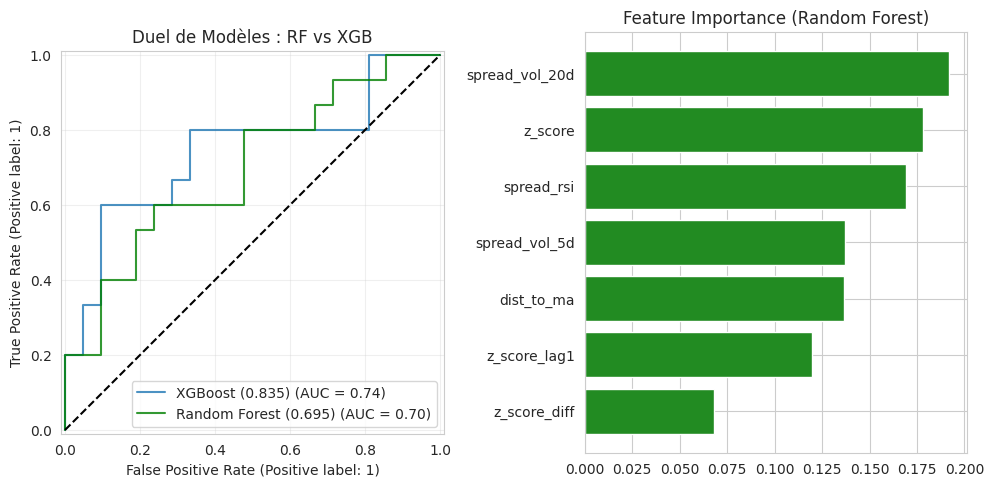

In [ ]:
#ON ESSAYE RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

print("--- Entraînement du Challenger : Random Forest ---")

# 1. Configuration du Modèle
# On utilise des paramètres robustes
model_rf = RandomForestClassifier(
    n_estimators=200,      # 200 arbres
    max_depth=5,           # Profondeur limitée pour éviter le par cœur sur peu de données
    min_samples_leaf=3,    # Il faut au moins 3 trades pour valider une feuille
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. Entraînement (Sur les mêmes X_train filtrés que XGBoost)
model_rf.fit(X_train, y_train)

# 3. Prédictions
proba_rf = model_rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

# 4. Évaluation
auc_rf = roc_auc_score(y_test, proba_rf)
acc_rf = accuracy_score(y_test, pred_rf)
f1_rf  = f1_score(y_test, pred_rf)

print(f"\n=== RÉSULTATS RANDOM FOREST ===")
print(f"ROC AUC    : {auc_rf:.3f}")
print(f"Accuracy   : {acc_rf:.3f}")
print(f"F1 Score   : {f1_rf:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred_rf))

# 5. Comparaison Visuelle : RF vs XGBoost
plt.figure(figsize=(10, 5))

# Plot A : Comparaison ROC
plt.subplot(1, 2, 1)
# On réaffiche la courbe XGBoost pour comparer
if 'proba_xgb' in locals():
    RocCurveDisplay.from_predictions(y_test, proba_xgb, name="XGBoost (0.835)", ax=plt.gca(), alpha=0.8)
RocCurveDisplay.from_predictions(y_test, proba_rf, name=f"Random Forest ({auc_rf:.3f})", ax=plt.gca(), color='green', alpha=0.8)
plt.plot([0, 1], [0, 1], "k--", label="Hasard")
plt.title("Duel de Modèles : RF vs XGB")
plt.grid(True, alpha=0.3)

# Plot B : Feature Importance RF
plt.subplot(1, 2, 2)
sorted_idx = model_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_rf.feature_importances_[sorted_idx], color='forestgreen')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()